# Getting some heatwave statistics

Here, heatwaves will be calculated and compared

In [41]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic_visualizations import plot_time_series, plot_map
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import percentileofscore
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


In [2]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'BE28'
model = "CCLM"

variable = "T_2M"
daily_statistic = "mean"
statistics = ["mean", "min", "max"]
begin_year = 1985
end_year = 2023

In [3]:
def get_extreme_days(dataarray, variable, x = 20):
    """
    Get the x most extreme days from an xarray DataArray containing daily temperatures.

    Parameters:
    dataarray (xarray.DataArray): An xarray DataArray with a 'time' dimension and temperature values.

    Returns:
    list: A list of tuples with the date and corresponding temperature for the x most extreme days.
    """
    if 'time' not in dataarray.dims:
        raise ValueError("The input DataArray must have a 'time' dimension.")

    x = x*2
    # Ensure the time coordinate is of datetime type
    dataarray['time'] = pd.to_datetime(dataarray['time'].values)

    # Convert to a pandas DataFrame for easy sorting
    df = dataarray.to_dataframe().reset_index()

    # Sort the DataFrame by variable in descending order
    sorted_df = df.sort_values(by=variable, ascending=False)

    # Extract the top x extreme days
    top_x = sorted_df.head(x)

    # Return as a dataframe (time, variable, date)
    top_x = top_x[["time", "T_2M"]]
    top_x["date"] = top_x['time'].dt.date
    top_x = top_x.drop_duplicates().reset_index(drop = True)

    
    return top_x

In [50]:
def highlight_extremes(da_serie: xr.DataArray, variable: str, x : int): 

    """
    Plots the yearly cycle for each year in a timesetie dataset (`da_point`), while highlighting the extreme moments,
    starting on January 1st for all.

    Parameters:
        da_serie (xarray.Dataset): Evaluation dataset with multiple years.
        variable (str): The name of the variable to plot.
        x : number of highest values that should be shown

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,6))
    
    top_x = get_extreme_days(da_serie, variable, x)

    top_x["doy"] = pd.to_datetime(top_x["date"]).dt.dayofyear
    top_x["year"] = pd.to_datetime(top_x["date"]).dt.year
    top_x = top_x.sort_values(by = "date")

    cmap = plt.cm.Reds
    norm = Normalize(vmin=top_x[variable].min(), vmax=top_x[variable].max())
    colors = cmap(norm(top_x[variable]))

    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_serie.time).year)
   
    # # Loop over all years:
    for yr in years_eval:
        ds_year = da_serie.sel(time=da_serie.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        if isinstance(ds_year, xr.Dataset):
            da_year = ds_year[variable]
        else:
            da_year = ds_year
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, color = "grey")

        indices = np.where(top_x["year"] == yr)[0]
        if indices.size > 0:
            top_year = top_x.iloc[indices]
            year_colors = cmap(norm(top_year[variable]))
            plt.scatter(top_year["doy"], top_year[variable], marker='o', c=year_colors, edgecolor='black', s = 50)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(f'{variable} Values')

    # Customize Plot
    #plt.title(f"Yearly Cycle of " + da_serie.long_name)
    plt.xlabel("Day of Year")
    #plt.ylabel(variable + " [" + da_serie.units + "]")
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()
    return top_x

In [5]:
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14),
    'uccle'     :(4.35, 50.80)
}
study_loc = "opwijk"


In [6]:
experiment = "CB2_CCLM_BEL28_ERA5_evaluation"
path = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/' + experiment + '/'+ experiment + '/' + variable + '/daily/'
files = [variable + "_" + "daily" + '_' + daily_statistic + "_"+  str(i) + '.nc' for i in np.arange(begin_year, end_year) ]


files_eval = [path + file for file in files]
print(files_eval)
ds_eval = xr.open_mfdataset(files_eval, combine='by_coords')


da_eval = ds_eval[variable]
da_eval

['/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1985.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1986.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1987.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1988.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1989.nc', '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation

<xarray.DataArray 'T_2M' (time: 13879, rlat: 320, rlon: 260)> Size: 5GB
dask.array<concatenate, shape=(13879, 320, 260), dtype=float32, chunksize=(366, 320, 260), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 111kB 1985-01-01T11:30:00 ... 2022-12-31...
    lon        (rlat, rlon) float32 333kB dask.array<chunksize=(320, 260), meta=np.ndarray>
    lat        (rlat, rlon) float32 333kB dask.array<chunksize=(320, 260), meta=np.ndarray>
  * rlon       (rlon) float32 1kB -3.263 -3.237 -3.213 ... 3.162 3.188 3.213
  * rlat       (rlat) float32 1kB -4.012 -3.987 -3.963 ... 3.912 3.938 3.963
    height_2m  float32 4B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: point

Text(0.5, 1.0, '2m temperature')

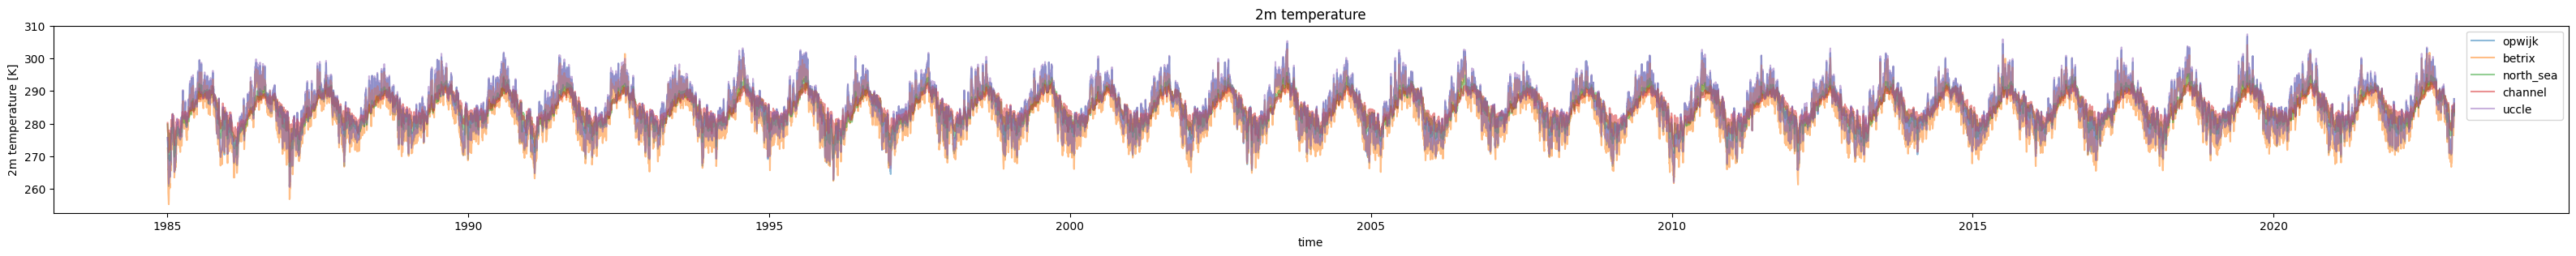

In [8]:
fig, ax = plt.subplots(figsize = (40,3))
d_da_point = {}
for i,point_id in enumerate(d_point_coords):
    point_coord = d_point_coords[point_id]
    da_point = select_point(ds_eval, point_coord, rotated_pole=True)
    d_da_point[point_id] = da_point

    da_point[variable].plot(ax=ax, label = point_id, alpha=0.5)
    ax.legend()
ax.set_title(da_eval.attrs['long_name'], loc='center')

In year 1985 we have 365 datapoints.
In year 1986 we have 365 datapoints.
In year 1987 we have 365 datapoints.
In year 1988 we have 366 datapoints.
In year 1989 we have 365 datapoints.
In year 1990 we have 365 datapoints.
In year 1991 we have 365 datapoints.
In year 1992 we have 366 datapoints.
In year 1993 we have 365 datapoints.
In year 1994 we have 365 datapoints.
In year 1995 we have 365 datapoints.
In year 1996 we have 366 datapoints.
In year 1997 we have 365 datapoints.
In year 1998 we have 365 datapoints.
In year 1999 we have 365 datapoints.
In year 2000 we have 366 datapoints.
In year 2001 we have 365 datapoints.
In year 2002 we have 365 datapoints.
In year 2003 we have 365 datapoints.
In year 2004 we have 366 datapoints.
In year 2005 we have 365 datapoints.
In year 2006 we have 365 datapoints.
In year 2007 we have 365 datapoints.
In year 2008 we have 366 datapoints.
In year 2009 we have 365 datapoints.
In year 2010 we have 365 datapoints.
In year 2011 we have 365 datapoints.
I

AttributeError: 'Dataset' object has no attribute 'long_name'

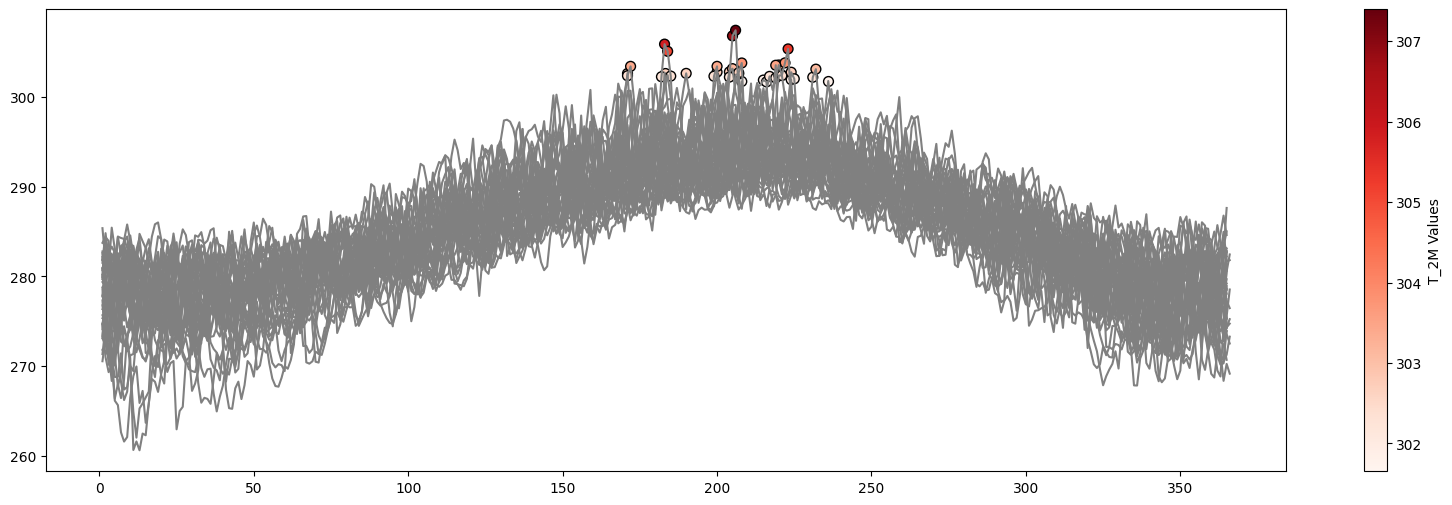

In [51]:
top_x = highlight_extremes(da_serie = da_point, variable = variable, x = 40)

In [38]:
np.where(top_x["year"] == 1995)

(array([6, 7]),)

In [ ]:
da_point = d_da_point[study_loc]
da_point["T_2M"]


<xarray.DataArray 'T_2M' (time: 13879)> Size: 56kB
dask.array<getitem, shape=(13879,), dtype=float32, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 111kB 1985-01-01T11:30:00 ... 2022-12-31...
    lon        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    rlon       float32 4B -0.0375
    rlat       float32 4B 0.4875
    height_2m  float32 4B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      2m temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: point

In [142]:
warmest_days = get_extreme_days(da_point, variable, 30)

warmest_days = warmest_days["date"].dt.dayofyear

AttributeError: Can only use .dt accessor with datetimelike values

In [138]:
warmest_days.drop_duplicates()

,time,T_2M,date
0,2019-07-25 11:30:00,306.713623,2019-07-25
2,2019-07-24 11:30:00,305.241150,2019-07-24
4,2003-08-11 11:30:00,304.565369,2003-08-11
6,2015-07-02 11:30:00,304.483398,2015-07-02
8,2015-07-03 11:30:00,304.340790,2015-07-03
10,2003-08-10 11:30:00,303.504486,2003-08-10
12,2018-07-27 11:30:00,303.448303,2018-07-27
14,2018-08-07 11:30:00,303.085846,2018-08-07
16,2022-07-19 11:30:00,303.010803,2022-07-19
18,2003-08-08 11:30:00,302.960449,2003-08-08


,time,T_2M
25247,2019-07-25 11:30:00,306.713623
25246,2019-07-25 11:30:00,306.713623
25245,2019-07-24 11:30:00,305.241150
25244,2019-07-24 11:30:00,305.241150
13592,2003-08-11 11:30:00,304.565369
13593,2003-08-11 11:30:00,304.565369
22279,2015-07-02 11:30:00,304.483398
22278,2015-07-02 11:30:00,304.483398
22280,2015-07-03 11:30:00,304.340790
22281,2015-07-03 11:30:00,304.340790
